# Gene Expression Classification with Autoencoder and Classifier

This notebook demonstrates a workflow for classifying gene expression data using an Autoencoder for dimensionality reduction followed by a simple neural network classifier. We'll generate synthetic gene expression data, train an Autoencoder to learn a lower-dimensional representation (latent space), and then train a classifier on these learned features.

--- 

## Imports



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import random

--- 

## Set Seeds for Reproducibility

Setting random seeds ensures that our results are reproducible. This is crucial for debugging and comparing different model configurations.

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

--- 

## Generate Synthetic Gene Expression Data

We create a function `generate_synthetic_gene_data` to simulate gene expression data. This synthetic dataset will have `num_samples` (e.g., patients), `num_genes` (e.g., gene features), and `num_classes` (e.g., disease subtypes). The data is designed to have distinct gene expression patterns for each class to make the classification task feasible.

In [3]:
def generate_synthetic_gene_data(num_samples=1000, num_genes=10000, num_classes=3):
    X = np.random.normal(0, 1, size=(num_samples, num_genes))
    y = np.random.randint(0, num_classes, size=(num_samples,))
    for i in range(num_classes):
        class_indices = np.where(y == i)[0]
        X[class_indices, i*100:(i+1)*100] += np.random.normal(3, 0.5, size=(len(class_indices), 100))
    return pd.DataFrame(X), pd.Series(y)

X, y = generate_synthetic_gene_data()

--- 

## Train-Test Split and Preprocessing

We split the data into training and testing sets to evaluate our model's generalization performance. `stratify=y` ensures that the proportion of classes is maintained in both sets. `StandardScaler` is used to normalize the gene expression values, which is important for neural networks.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

--- 

## Define Autoencoder

An Autoencoder is a neural network trained to reconstruct its input. It consists of an **encoder** that maps the input to a lower-dimensional latent space and a **decoder** that reconstructs the input from this latent space. The `latent_dim` is a crucial hyperparameter, representing the dimensionality of the compressed representation.

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512), nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

--- 

## Train Autoencoder

The Autoencoder is trained using `MSELoss` (Mean Squared Error) as the criterion, aiming to minimize the difference between the input and its reconstruction. The Adam optimizer is used for updating the model's weights.

In [6]:
autoencoder = Autoencoder(input_dim=10000, latent_dim=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    autoencoder.train()
    reconstructed, _ = autoencoder(X_train_tensor)
    loss = criterion(reconstructed, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

c:\Users\techt\anaconda3\envs\pytorch_cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/10, Loss: 1.0049
Epoch 2/10, Loss: 1.0003
Epoch 3/10, Loss: 0.9960
Epoch 4/10, Loss: 0.9920
Epoch 5/10, Loss: 0.9880
Epoch 6/10, Loss: 0.9832
Epoch 7/10, Loss: 0.9772
Epoch 8/10, Loss: 0.9701
Epoch 9/10, Loss: 0.9621
Epoch 10/10, Loss: 0.9538


--- 

## Extract Latent Features

After training, we use the encoder part of the Autoencoder to extract the learned latent features for both the training and testing datasets. These lower-dimensional features will be used as input for our classifier.

In [7]:
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor)
    _, X_test_latent = autoencoder(X_test_tensor)

--- 

## Define Classifier

We define a simple feed-forward neural network classifier that takes the `latent_dim` (64 in this case) as input and outputs scores for each of the `num_classes` (3 in this case). `CrossEntropyLoss` is suitable for multi-class classification problems.

In [8]:
classifier = nn.Sequential(
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 3)
)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=1e-3)

--- 

## rain Classifier

The classifier is trained on the latent features extracted by the Autoencoder. The training process is similar to that of the Autoencoder, but here we optimize for classification accuracy using `CrossEntropyLoss`.

In [9]:
epochs_cls = 10
for epoch in range(epochs_cls):
    classifier.train()
    outputs = classifier(X_train_latent)
    loss = criterion_cls(outputs, y_train_tensor)
    optimizer_cls.zero_grad()
    loss.backward()
    optimizer_cls.step()
    print(f"[Classifier] Epoch {epoch+1}/{epochs_cls}, Loss: {loss.item():.4f}")

[Classifier] Epoch 1/10, Loss: 1.1557
[Classifier] Epoch 2/10, Loss: 1.1326
[Classifier] Epoch 3/10, Loss: 1.1099
[Classifier] Epoch 4/10, Loss: 1.0876
[Classifier] Epoch 5/10, Loss: 1.0656
[Classifier] Epoch 6/10, Loss: 1.0440
[Classifier] Epoch 7/10, Loss: 1.0227
[Classifier] Epoch 8/10, Loss: 1.0016
[Classifier] Epoch 9/10, Loss: 0.9808
[Classifier] Epoch 10/10, Loss: 0.9601


--- 

## Evaluate Classifier

After training, we evaluate the classifier's performance on the unseen test set. We use `classification_report` to get a detailed breakdown of precision, recall, and F1-score for each class.

In [10]:
classifier.eval()
with torch.no_grad():
    preds = classifier(X_test_latent)
    preds_label = torch.argmax(preds, dim=1)
    print(classification_report(y_test_tensor, preds_label))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        68
           1       1.00      0.32      0.49        68
           2       0.79      0.95      0.87        64

    accuracy                           0.76       200
   macro avg       0.82      0.76      0.72       200
weighted avg       0.82      0.76      0.72       200



--- 

## Confusion Matrix

A confusion matrix provides a visual summary of the classification performance, showing the number of correct and incorrect predictions for each class. This helps in understanding which classes are being confused with others.

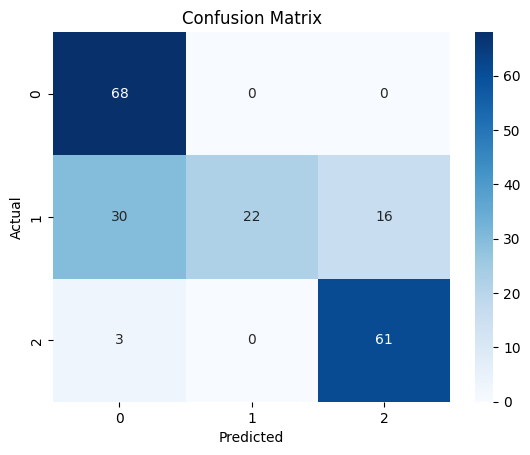

In [11]:
cm = confusion_matrix(y_test_tensor, preds_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

--- 

## Cell 12: Visualize Latent Space with PCA

To understand the latent representation learned by the Autoencoder, we apply Principal Component Analysis (PCA) to reduce the 64-dimensional latent space to 2 dimensions. This allows us to visualize the clusters formed by different classes in the latent space.

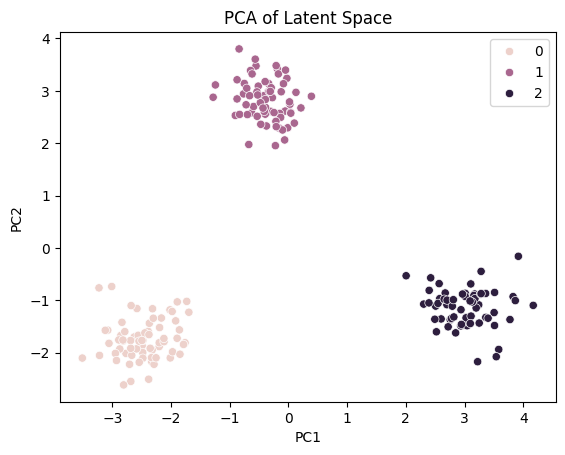

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_latent.numpy())
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_tensor)
plt.title("PCA of Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

---